<font color=#BD2505><h1 style=text-align:center>COMP41680- Data Science in Python</h1>

<font color=Maroon><h2 style=text-align:center> Assignment 2 </h2>

<font color=#340B87><h2 style=text-align:center>Student ID: 17200461</h2></font>

## Import Packages 

In [1]:
# Import necessary packages
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import bs4

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn import naive_bayes

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer


import operator
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib
import matplotlib.pyplot as plt
# Important! Need to tell IPython to display plots within the notebook
%matplotlib inline


# <font color=maroon> Part 1 : Data Collection </font>

**I have scraped the data in two parts. **
* **The first part will generate the list of all the monthly news article links. **
* **The second part will scrap the content present in each monthly link.**


In [2]:
#I have created three functions. 
    # The first function will request these links to open and parse the html content using BeautifulSoup.
    # The second function will open the files in write mode.
    # The third function will open the files in append mode.


# To open the link
def open_link(baseurl,newurl):
    rawtext = urllib.request.urlopen(baseurl+newurl)
    soup = bs4.BeautifulSoup(rawtext,'html.parser')
    return soup

# To open the file in 'w' mode
def create_raw_file(category_file,article_file):
    
    # open category file
    with open(category_file, 'w', encoding='utf-8') as raw_category_file:
        raw_category_file.close()
    
    # open article file
    with open(article_file, 'w', encoding="utf-8") as raw_article_file:
        raw_article_file.close()
    
# To open the file in 'a' mode
def create_file(category_file,article_file,category,article_text):
    #category file include news-categories
    with open(category_file,'a', encoding='utf-8') as file:
        file.write(category + '\n')
    file.close()
    
    #article file include news-articles
    with open(article_file,'a', encoding='utf-8') as file:
        file.write(article_text + '\n')
    file.close()

In [3]:
# This is the base url which will be appended with new urls got during web scraping.

baseurl='http://mlg.ucd.ie/modules/COMP41680/archive/'

In [4]:
# The first part of scraping to get the monthly news articles link

index_page=open_link(baseurl,'index.html')
monthly_data=index_page.find('div', attrs={'class':'main'}).find_all('li')
monthly_url=[]
for data in monthly_data:
    monthly_url.append(data.find('a').attrs['href'])
print(monthly_url)

['month-jan-2017.html', 'month-feb-2017.html', 'month-mar-2017.html', 'month-apr-2017.html', 'month-may-2017.html', 'month-jun-2017.html', 'month-jul-2017.html', 'month-aug-2017.html', 'month-sep-2017.html', 'month-oct-2017.html', 'month-nov-2017.html', 'month-dec-2017.html']


In [5]:

# The second part will scrap the inner content of each months which include categories and article links
# Then open the article links and get the article contents

category_elements=''
category_file='news_categories.txt'
article_file='news_articles.txt'
create_raw_file(category_file,article_file)

# first loop will iterate over each month and find the <tr> tags
for url in monthly_url:
    monthly_stories=open_link(baseurl,url) # open the monthly links
    contents=monthly_stories.find('div', attrs={'class':'main'}).find_all('tr') # find all values in <tr> tag
    
    # second for loop will go row by row and will get the category using category-class and respective article link using title-class
    for row_data in contents[1:]:
        get_categories=row_data.find('td', attrs={'class':'category'}) # the categories are in class= category
        get_article_urls = row_data.find('td', class_='title')  # the article links are in class= title
        
        if((get_categories.text != 'N/A') and (get_article_urls.find('a') != None)): # to check if 'N/A' or None value exists
            category_elements=get_categories.text.strip() # use strip to remove the spaces
            article_urls = get_article_urls.find('a').attrs['href'] # find the article urls
            articles = ''
            get_article_contents= open_link(baseurl,article_urls) # call to open_link function declared above
            articles += get_article_contents.find('div', attrs={'class':'main'}).find('h2').text + ' ' # Get Title of news. Here I am adding a space at the end so that there will be separation between header and the paragrah
            article_text=get_article_contents.find('div', attrs={'class':'main'}).find_all('p') # find all <p> tags
            # third loop to get the news-text
            for mytext in article_text[:-1]: # using -1 because the last <p> content is not relevant to scraping requirement.
                articles += mytext.text # add the content one by one in article list generated above
            create_file(category_file,article_file,category_elements,articles) # call the create_file function by passing file names and category_elements and article_text

print('******************************')
print('Done with Web Scraping')
print('******************************')

******************************
Done with Web Scraping
******************************


# <font color=maroon> Part 2 : Text Classification </font>
<br>
<font><b> Task 1: From the files created in Part 1, I have load the set of raw documents. I am creating a DataFrame to ensure if the class labels i.e. Categories and the Data i.e. news-content properly matches with each other <br><br>

Task 2: From the raw documents, I am creating a document-term matrix, using appropriate text pre-processing and term weighting steps. <br><br>

Task 3: I am using two multi-class classification models as Decision Tree and Naive Bayes.<br><br>

Task 4: I am comparing the predictions of the two classification models using One-way holdout and Cross-Validation evaluation strategy. Lastly, I am visualizing the mean accuracy scores got from Cross-Validation results on bar graph plot.</b> </font>

## <font color=#340B87>Task 1 : Loading the Raw_documents</font>

I am loading the two files 1. news_categories.txt and 2. news_articles.txt which contains the categories and content of the news articles respectively.

In [6]:
# read the news-categories file which contains categories i.e. class labels of the articles
f_category = open('news_categories.txt','r', encoding='utf-8')
news_labels = f_category.read().splitlines()
f_category.close()

#read the news-articles file which contains the text of the articles
f_article = open('news_articles.txt','r', encoding='utf-8')
news_content = f_article.read().splitlines()
f_article.close()

### Representing data using Data Frame

In [7]:
# create a DataFrame to check the mapping of categories with respective article contents

df=pd.DataFrame(news_content,news_labels)
df.index.name='News_Categories'
df.columns=['Article Content']
df.head(10)


,Article Content
News_Categories,
technology,21st-Century Sports: How Digital Technology Is...
business,Asian quake hits European shares Asian quake h...
technology,BT offers free net phone calls BT is offering ...
business,Barclays shares up on merger talk Barclays sha...
sport,Barkley fit for match in Ireland England centr...
sport,Bellamy under new fire Bellamy under new fireN...
sport,Benitez 'to launch Morientes bid' Benitez 'to ...
sport,Benitez delight after crucial win Liverpool ma...
technology,Big war games battle it out The arrival of new...


## <font color=#340B87>Task 2 : Creating Document-Term Matrix</font>
<br>
<font><b> I am using different vectorizer models under Bag-of-words model approach using Scikit learn packages.</b><br><br>

<b>1. Normal Vectorizer:</b> In this, normal CountVectorizer() function is called without passing any arguments. <br><br>
<b>2. N-Gram Vectorizer:</b> In this, CountVectorizer() is passed with n-gram argument where n=2 i.e. bi-grams. <br><br>
<b>3. Vectorizer with Pre-Processing Text:</b> In this, the CountVectorizer() is passed with different pre-processing steps like StopWord removal (which will remove stop words like and,the, that etc), Low-frequency filtering (it will remove the words that appear in very few documents having frequency lower than specified)  and Lemmatizing (it uses the existing word vocabulary and does morphological analysis). I am not using Stemming here because Stemming does not return meaningful terms and hence it may affect the accuracy. <br><br>
<b>4. Tf-Idf Vectorizer:</b> In order to improve the usefulness of the Document-Term Matrix, it is necessary to assign weights to the terms that are more important. Therefore, I will be passing the same pre-processing parameters used in above CountVectorizer with pre-processing text.</font>

### Normal Vectorizer

Using CountVectorizer without passing any pre-processing arguments i.e. creating matrix directly on raw data

In [8]:
# Using Bag-of-words model approach
# normal vectorizer

norm_vectorizer = CountVectorizer()
X_normal = norm_vectorizer.fit_transform(news_content)
print(X_normal.shape)

terms = norm_vectorizer.get_feature_names()
vocab = norm_vectorizer.vocabulary_
print("Vocabulary has %d distinct terms" % len(terms))
print(vocab['earthquake'])

(1408, 23648)
Vocabulary has 23648 distinct terms
7345


### N-gram Vectorizer

The vocabulary size increases as bi-grams are considered. Therefore the size of vocabulary is increased and hence the sparcity in the matrix also increases. So using only n-gram in vectorizer wont be a good choice.

In [9]:
# n-gram vectorizer

n_gram_vectorizer = CountVectorizer(ngram_range = (1,2)) # extracting single token and bigrams
X_n_gram = n_gram_vectorizer.fit_transform(news_content)
print(X_n_gram.shape)

terms = n_gram_vectorizer.get_feature_names()

print("Vocabulary has %d distinct terms" % len(terms))

(1408, 254999)
Vocabulary has 254999 distinct terms


### Vectorizer with Pre-Processing Text

Pre-Processing includes removing the stop words (sklearn contains list of default stop words), removing words with low frequency that appears in very few documents, and perform lemmatization to do morphological analysis. Hence, the problem of sparcity in the matrix dicussed above can be reduced by these pre-processing parameters.

In [10]:
# Using Lemma tokenizer

# define the function
def lemmatize_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens_list = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    nltk_lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatize_tokens = []
    for token in tokens_list:
        lemmatize_tokens.append( nltk_lemmatizer.lemmatize(token) )
    return lemmatize_tokens

In [11]:
# using pre-processing parameters like stopwords removal, low frequency filtering and lemmatization respectively

lemma_vectorizer = CountVectorizer(stop_words="english",min_df = 5,tokenizer=lemmatize_tokenizer)
X_lemma = lemma_vectorizer.fit_transform(news_content)
print(X_lemma.shape)

(1408, 6098)


### Term Weighting using Tfidf Vectorizer

Here I am using Tfidf vectorizer instead of CountVectorizer. The arguments considered are same i.e. the pre-processing parameters are same viz. stopwords removal, low frequency filtering and lemmatization.

In [12]:
# pass the same preprocessing parameters which were passed in above cell
tfidf_vectorizer = TfidfVectorizer(stop_words="english",min_df = 5, tokenizer=lemmatize_tokenizer)
X_tfidf = tfidf_vectorizer.fit_transform(news_content)
print(X_tfidf.shape)

(1408, 6098)


C:\Users\pnkjs\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### Measuring Similarity

Similarity between different documents can be found using Cosine Similarity measure. I am taking the example of similarity for first document with rest of the documents in the file. I am trying this on the different vectorizer models I used above.

In [13]:
# To measure the cosine similarity between the first document and rest others for normal_vectorizer
max_cosine = 0
similar_row = 0
for row in range(1,X_normal.shape[0]):
    cos_result = cosine_similarity( X_normal[0], X_normal[row] )
    # best so far?
    if cos_result > max_cosine:
        max_cosine = cos_result
        similar_row = row
print("Most similar document was row %d: cosine similarity = %.3f" % ( similar_row, max_cosine ) )

print(news_labels[similar_row])
print(news_content[similar_row][0:300])

Most similar document was row 627: cosine similarity = 0.713
business
Giant waves damage S Asia economy Governments, aid agencies, insurers and travel firms are among those counting the cost of the massive earthquake and waves that hammered southern Asia.The worst-hit areas are Sri Lanka, India, Indonesia and Thailand, with at least 23,000 people killed. Early estimat


In [14]:
# To measure the cosine similarity between the first document and rest others for n-gram vectorizer
max_cosine = 0
similar_row = 0
for row in range(1,X_n_gram.shape[0]):
    cos_result = cosine_similarity( X_n_gram[0], X_n_gram[row] )
    # best so far?
    if cos_result > max_cosine:
        max_cosine = cos_result
        similar_row = row
print("Most similar document was row %d: cosine similarity = %.3f" % ( similar_row, max_cosine ) )

print(news_labels[similar_row])
print(news_content[similar_row][0:300])

Most similar document was row 627: cosine similarity = 0.594
business
Giant waves damage S Asia economy Governments, aid agencies, insurers and travel firms are among those counting the cost of the massive earthquake and waves that hammered southern Asia.The worst-hit areas are Sri Lanka, India, Indonesia and Thailand, with at least 23,000 people killed. Early estimat


In [15]:
# To measure the cosine similarity between the first document and rest others for lemma-vectorizer
max_cosine = 0
similar_row = 0
for row in range(1,X_lemma.shape[0]):
    cos_result = cosine_similarity( X_lemma[0], X_lemma[row] )
    # best so far?
    if cos_result > max_cosine:
        max_cosine = cos_result
        similar_row = row
print("Most similar document was row %d: cosine similarity = %.3f" % ( similar_row, max_cosine ) )

print(news_labels[similar_row])
print(news_content[similar_row][0:300])

Most similar document was row 801: cosine similarity = 0.305
technology
Technology gets the creative bug Technology gets the creative bugThe hi-tech and the arts worlds have for some time danced around each other and offered creative and technical help when required.Often this help has come in the form of corporate art sponsorship or infrastructure provision. But that d


In [16]:
# To measure the cosine similarity between the first document and rest others for tfidf vectorizer
max_cosine = 0
similar_row = 0
for row in range(1,X_tfidf.shape[0]):
    cos_result = cosine_similarity( X_tfidf[0], X_tfidf[row] )
    # best so far?
    if cos_result > max_cosine:
        max_cosine = cos_result
        similar_row = row
print("Most similar document was row %d: cosine similarity = %.3f" % ( similar_row, max_cosine ) )

print(news_labels[similar_row])
print(news_content[similar_row][0:300])

Most similar document was row 1027: cosine similarity = 0.189
technology
Sporting rivals go to extra time The current slew of sports games offers unparalleled opportunities for fans who like to emulate on-field action without ever moving from the couch.The two giants in the field - ESPN and EA Sports - have been locked in a heavyweight battle for years. The latter is the


** Here the normal vectorizer model and n-gram vectorizer model returns the same index document as similar but with different cosine values, whereas, the other two vectorizer model finds different document as similar.However, the last two vectorizers return the match with same news-category as that of first document. This is because, each vectorizer model here is having different or no parameters for processing, and in last two vectorizer we do some pre-processing on the text which helps in identifing similar category document. You can decide what all pre-processing is required as per target requirements.**

## <font color=#340B87>Task 3 and 4 : Evaluation Experiments and Classification algorithms</font>
** I am considering the outputs from two different Vectorizers used to create document-term matrix. These outputs will be used for predicting the documents using different evaluation techniques of Classification models.**
* **TfidfVectorizer() s X_tfidf**
* **CountVectorizer() as X_lemma ( Vectorizer with Pre-Processing)**


** I am performing the evaluation experiments on the news_contents document using two types of evaluating techniques.**
   * **One-way HoldOut Strategy (Train and Test Split) **
   * ** K-Fold Cross Validation  **
   

### Using data from X_tfidf Vectorizer model

### Evaluating using Simple Train/Test Split

- Performing 70-30 split as Train-Test on raw data
- The toarray() function is used to deal with sparsity which might get produced during the use of Vectorizers. And then this data is used for Training and Testing.

In [17]:
# As the document-matrix generated is sparse, I am taking calling toarray() function, so that the sparcity does not affect the accuracy.
X = X_tfidf.toarray()
Y = np.array(news_labels) # labels are taken as simple np-arrays

# Split the raw data as 70-30 Train-Test 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, train_size=0.7, test_size=0.3)

### Decision Tree Classifier

In [18]:
# Using Decision Tree Classifier and calling fit function
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [19]:
# Make a set of predictions for the training data
Y_predict = decisionTree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(Y_test, Y_predict)
print("Accuracy Score: " + str(accuracy))
print(metrics.classification_report(Y_test, Y_predict))

# Print Confusion Matrix
print("Confusion Matrix: ")
pd.crosstab(np.array(Y_test), Y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score: 0.8676122931442081
             precision    recall  f1-score   support

   business       0.81      0.84      0.83       138
      sport       0.90      0.91      0.90       170
 technology       0.89      0.84      0.87       115

avg / total       0.87      0.87      0.87       423

Confusion Matrix: 


Predicted,business,sport,technology,All
True,,,,
business,116,10,12,138
sport,16,154,0,170
technology,11,7,97,115
All,143,171,109,423


### Evaluating using 10-fold Cross-Validation

In [20]:
# call the cross_val_scores function
acc_scores_dt = cross_val_score(decisionTree, X, Y, cv=10, scoring="accuracy")
mean_scores_dt=acc_scores_dt.mean()
print("Decision Tree: Mean cross-validation accuracy = %.2f" % mean_scores_dt )

Decision Tree: Mean cross-validation accuracy = 0.89


### Naive Bayes Classifier

In [21]:
# Using Naive Bayes Classifier and calling fit function
n_bayes = naive_bayes.MultinomialNB()
n_bayes.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
# Make a set of predictions for the training data
Y_predict = n_bayes.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(Y_test, Y_predict)
print("Accuracy Score: " + str(accuracy))
print(metrics.classification_report(Y_test, Y_predict))

# Print Confusion Matrix
print("Confusion Matrix: ")
pd.crosstab(np.array(Y_test), Y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score: 0.9787234042553191
             precision    recall  f1-score   support

   business       0.97      0.98      0.97       138
      sport       0.99      0.98      0.99       170
 technology       0.97      0.97      0.97       115

avg / total       0.98      0.98      0.98       423

Confusion Matrix: 


Predicted,business,sport,technology,All
True,,,,
business,135,0,3,138
sport,3,167,0,170
technology,1,2,112,115
All,139,169,115,423


In [23]:
# call the cross_val_scores function
acc_scores_nb = cross_val_score(n_bayes, X, Y, cv=10, scoring="accuracy")
mean_scores_nb=acc_scores_nb.mean()
print("Naive Bayes: Mean cross-validation accuracy = %.2f" % mean_scores_nb )

Naive Bayes: Mean cross-validation accuracy = 0.98


### Plotting Graphs

**I will be considering the mean accuracy scores generated by cross_val_scores() of each classifier model for plotting**

**<font color=red>The evaluation done by One-way holdout i.e. Train-Test split works on limited amount of data and hence we can get different accuracy for each time we run the code. However, k-fold cross validation is performed on whole data and it avoids random selection.</font> **

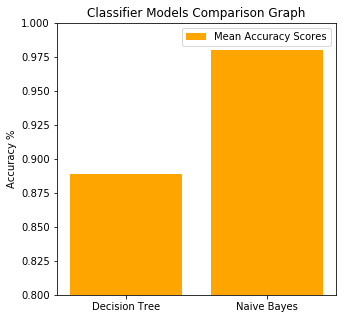

In [24]:
# Set the bar labels
bar_labels = ['Decision Tree', 'Naive Bayes']

# Create the x position of the bars and give bar graph parameters
N=2
x_pos = np.arange(N)

# Create the plot bars
accuracy_scores=(mean_scores_dt,mean_scores_nb)

#We can plot other performance factors like F1-measures along with Accuracy, therefore we can use subplots.
fig, ax =plt.subplots(figsize=(5,5))

# Plot a bar graph. 
plt.bar([p for p in x_pos],# using the data from the mean_values
        accuracy_scores, 
        color='orange'
        )

# Set the chart's title
ax.set_title('Classifier Models Comparison Graph')

# set axes labels and title
ax.set_ylabel('Accuracy %')
ax.set_xticks([p for p in x_pos])
ax.set_xticklabels(bar_labels)
plt.ylim(0.8,1)
plt.legend(['Mean Accuracy Scores'])
plt.show()

### Using data from X_lemma Vectorizer model

- Performing the same steps as done for X_tfidf

### Evaluating using Simple Train/Test Split

In [25]:
# putting data from Vectorizer with pre-processing i.e X_lemma
# As the document-matrix generated is sparse, I am taking calling toarray() function, so that the sparcity does not affect the accuracy.
X_lem_vec = X_lemma.toarray()
Y_lem_vec = np.array(news_labels) # labels are taken as simple np-array

X_train, X_test, Y_train, Y_test = train_test_split(X_lem_vec, Y_lem_vec, random_state=0, train_size=0.7, test_size=0.3)

### Decision Tree Classifier Model

In [26]:
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
# Make a set of predictions for the training data
Y_predict = decisionTree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(Y_test, Y_predict)
print("Accuracy Score: " + str(accuracy))
print(metrics.classification_report(Y_test, Y_predict))

# Print Confusion Matrix
print("Confusion Matrix: ")
pd.crosstab(np.array(Y_test), Y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score: 0.8723404255319149
             precision    recall  f1-score   support

   business       0.80      0.86      0.83       138
      sport       0.94      0.89      0.91       170
 technology       0.87      0.86      0.86       115

avg / total       0.88      0.87      0.87       423

Confusion Matrix: 


Predicted,business,sport,technology,All
True,,,,
business,119,6,13,138
sport,17,151,2,170
technology,12,4,99,115
All,148,161,114,423


### Evaluating using Cross-Validation

In [28]:
acc_scores_dt = cross_val_score(decisionTree, X_lem_vec, Y_lem_vec, cv=10, scoring="accuracy")
mean_scores_dt=acc_scores_dt.mean()
print("Decision Tree: Mean cross-validation accuracy = %.2f" % mean_scores_dt )

Decision Tree: Mean cross-validation accuracy = 0.90


### Naive Bayes Classifier Model

In [29]:
n_bayes = naive_bayes.MultinomialNB()
n_bayes.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# Make a set of predictions for the training data
Y_predict = n_bayes.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(Y_test, Y_predict)
print("Accuracy Score: " + str(accuracy))
print(metrics.classification_report(Y_test, Y_predict))

# Print Confusion Matrix
print("Confusion Matrix: ")
pd.crosstab(np.array(Y_test), Y_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy Score: 0.9787234042553191
             precision    recall  f1-score   support

   business       0.96      0.98      0.97       138
      sport       0.99      0.98      0.99       170
 technology       0.97      0.98      0.98       115

avg / total       0.98      0.98      0.98       423

Confusion Matrix: 


Predicted,business,sport,technology,All
True,,,,
business,135,0,3,138
sport,4,166,0,170
technology,1,1,113,115
All,140,167,116,423


### Evaluating using Cross-Validation

In [31]:
acc_scores_nb = cross_val_score(n_bayes, X_lem_vec, Y_lem_vec, cv=10, scoring="accuracy")
mean_scores_nb=acc_scores_nb.mean()
print("Naive Bayes: Mean cross-validation accuracy = %.2f" % mean_scores_nb )

Naive Bayes: Mean cross-validation accuracy = 0.98


### Plotting Graphs

**I will be considering the mean accuracy scores generated by cross_val_scores() of each classifier model.**

** <font color=red>The evaluation done by One-way holdout i.e. Train-Test split works on limited amount of data and hence we can get different accuracy for each time we run the code. However, k-fold cross validation is performed on whole data and it avoids random selection. Therfore, I am using the K-Fold Cross validation for analysis purpose.</font> **

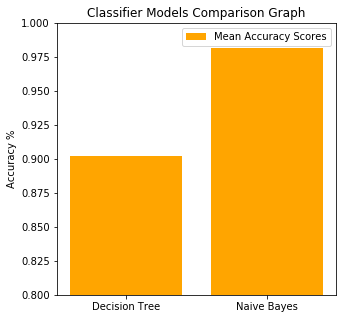

In [32]:
# Set the bar labels
bar_labels = ['Decision Tree', 'Naive Bayes']

# Create the x position of the bars and give bar graph parameters
N=2
x_pos = np.arange(N)

# Create the plot bars
accuracy_scores=(mean_scores_dt,mean_scores_nb)

#We can plot other performance factors like F1-measures along with Accuracy, therefore we can use subplots.
fig, ax =plt.subplots(figsize=(5,5))

# Plot a bar graph. 
plt.bar([p for p in x_pos],# using the data from the mean_values
        accuracy_scores, 
        color='orange'
        )

# Set the chart's title
ax.set_title('Classifier Models Comparison Graph')

# set axes labels and title
ax.set_ylabel('Accuracy %')
ax.set_xticks([p for p in x_pos])
ax.set_xticklabels(bar_labels)
plt.ylim(0.8,1)
plt.legend(['Mean Accuracy Scores'])
plt.show()

## Observation and Analysis

<font color=green> <b> Observation:<br>
1. From the two graphs generated above. It can be observed that Machine Learning Classifiers trained on Document-Term Matrix generated by Pre-Processed CountVectorizer Model give good accuracy scores than Tf-Idf Vectorizer model. The accuracy for Decision Tree and Naive Bayes comes as 89% and 98% respectively for TfidfVectorizer model. Whereas, the accuracy for Decision Tree and Naive Bayes comes as 90% and 98% respectively for CountVectorizer model.  <br>
2. It can be observed that Naive Bayes Classifier performs well than Decision Tree Classifier in both the approaches i.e. Vectorizer models.Decision Tress has 89% and 90% accuracy for each vectorizer respectively, and Naive Bayes gives 98% accuracy for each Vectorizer model.</b></font> <br>

<font color=green> <b> Analysis:<br>
1. The CountVectorizer() as the name gives counts the frequencies of the words, whereas for TfidfVectorizer(), the values increases in proportion with the count, but is offset by the frequency of that word in all documents. Here, in our news-article content, there might be some words whose word frequency gives better result than the term weighting. And therefore, the accuracy for both the classifier is more/same in CountVectorizer model than TfidfVectorizer model.<br>
2. The Decision Tree classifiers forms the nested tree structure as per the features and assigns respective class-labels at the leaf nodes. Whereas, Naive Bayes gives the probability of that feature occurence. Naive Bayes assumes conditional independencies between the features. As a result, in our news-articles context there might not be much dependencies between the words and hence,Multinomial Naive Bayes is specially used for text classification because it uses discrete features(here terms) and hence it performs well and give high accuracy scores for both Vectorizer models than Decision Tree.